In [ ]:
install.packages("tidyverse")

also installing the dependencies ‘rematch’, ‘gargle’, ‘cellranger’, ‘ids’, ‘vroom’, ‘tzdb’, ‘selectr’, ‘broom’, ‘dtplyr’, ‘forcats’, ‘googledrive’, ‘googlesheets4’, ‘haven’, ‘lubridate’, ‘modelr’, ‘readr’, ‘readxl’, ‘reprex’, ‘rvest’




In [ ]:
library("here")
library(devtools)
library(Seurat)
library(harmony)
library(RcppML)
library(reshape2)
library(tidyverse)
load_all('/home/jpm73279/Socrates')
data_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/QC_output/"

set.seed(12345)



In [ ]:

library(randomcoloR)
other <- randomcoloR::distinctColorPalette(k = 55)
other <- sample(other)

In [3]:
# bed <- system.file("extdata", "test.tn5.bed.gz", package = "Socrates")
#ann <- system.file("extdata", "gencode.v19.annotation.gff3.gz", package = "Socrates")
#chr <- system.file("extdata", "hg19.txt", package = "Socrates")

reference_genome_path <- "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/"
analysis_path <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/sorghum_bicolor/"

sb_leaf_rep_1 <- paste0(analysis_path, "Sorghum_leaf.sciATAC.merged.unique.tn5.sorted.bed")

# set-up arguments

#ann <- "Zm-B73-REFERENCE-NAM-5.0_Zm00001eb.1.nuclear.gff3"
#chr <- "Zm-B73-REFERENCE-NAM-5.0.chrom.size"
#pre <- "Sb.Leaf_rep1"
#output <- as.character(args[5])

ann <- paste0(reference_genome_path,"Sbicolorv5.1.primaryTrs.gff3")
chr <- paste0(reference_genome_path,"Sorghum_bicolor_var_BTx623.chrom.size")
pre <- "Sb.Leaf_merged_reps"



#Load Object
Sb.subcluster <- loadBEDandGenomeData(sb_leaf_rep_1, ann, chr)
#zea_m.rep.peaks  <- paste0(pre, "macs2_temp", sep=".")

Running pre-check on input files and executable paths ...

BED file path = /scratch/jpm73279/comparative_single_cell/01.alignments_annotations/sorghum_bicolor/Sorghum_leaf.sciATAC.merged.unique.tn5.sorted.bed ... ok

GFF file path = /home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sbicolorv5.1.primaryTrs.gff3 ... ok

Chromosome sizes file path = /home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sorghum_bicolor_var_BTx623.chrom.size ... ok

Macs2 is installed .... ok

 - loading data (this may take obj while for big BED files) ...

 - finished loading data



In [4]:

marker_list_sb_file <- "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/markers/Sb.leaf_markers_from_zm.markers.txt"
marker_list_sb <- read_delim(marker_list_sb_file, delim='\t', 
                                       col_names = TRUE)

Rows: 151 Columns: 7
── Column specification ───────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): chr, geneID, name, type, tissue
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
loaded_socrates_data <- readRDS("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/Sb.annotation_V3t.LC_results.rds")

In [6]:

sb.loaded_socrates_data.epidermal <- loaded_socrates_data
cleaned_cluster_meta <- sb.loaded_socrates_data.epidermal$Clusters  %>% 
        group_by(LouvainClusters)  %>% 
        mutate(Louvain_cluster_safe = str_c("LouvainC_", LouvainClusters))
    
sb.loaded_socrates_data.epidermal$Clusters <- cleaned_cluster_meta

## SubClustering Epidermal Lineages:
"LouvainC_2", "LouvainC_12", "LouvainC_20", 
"LouvainC_4", "LouvainC_6", "LouvainC_18",
"LouvainC_15", "LouvainC_1"

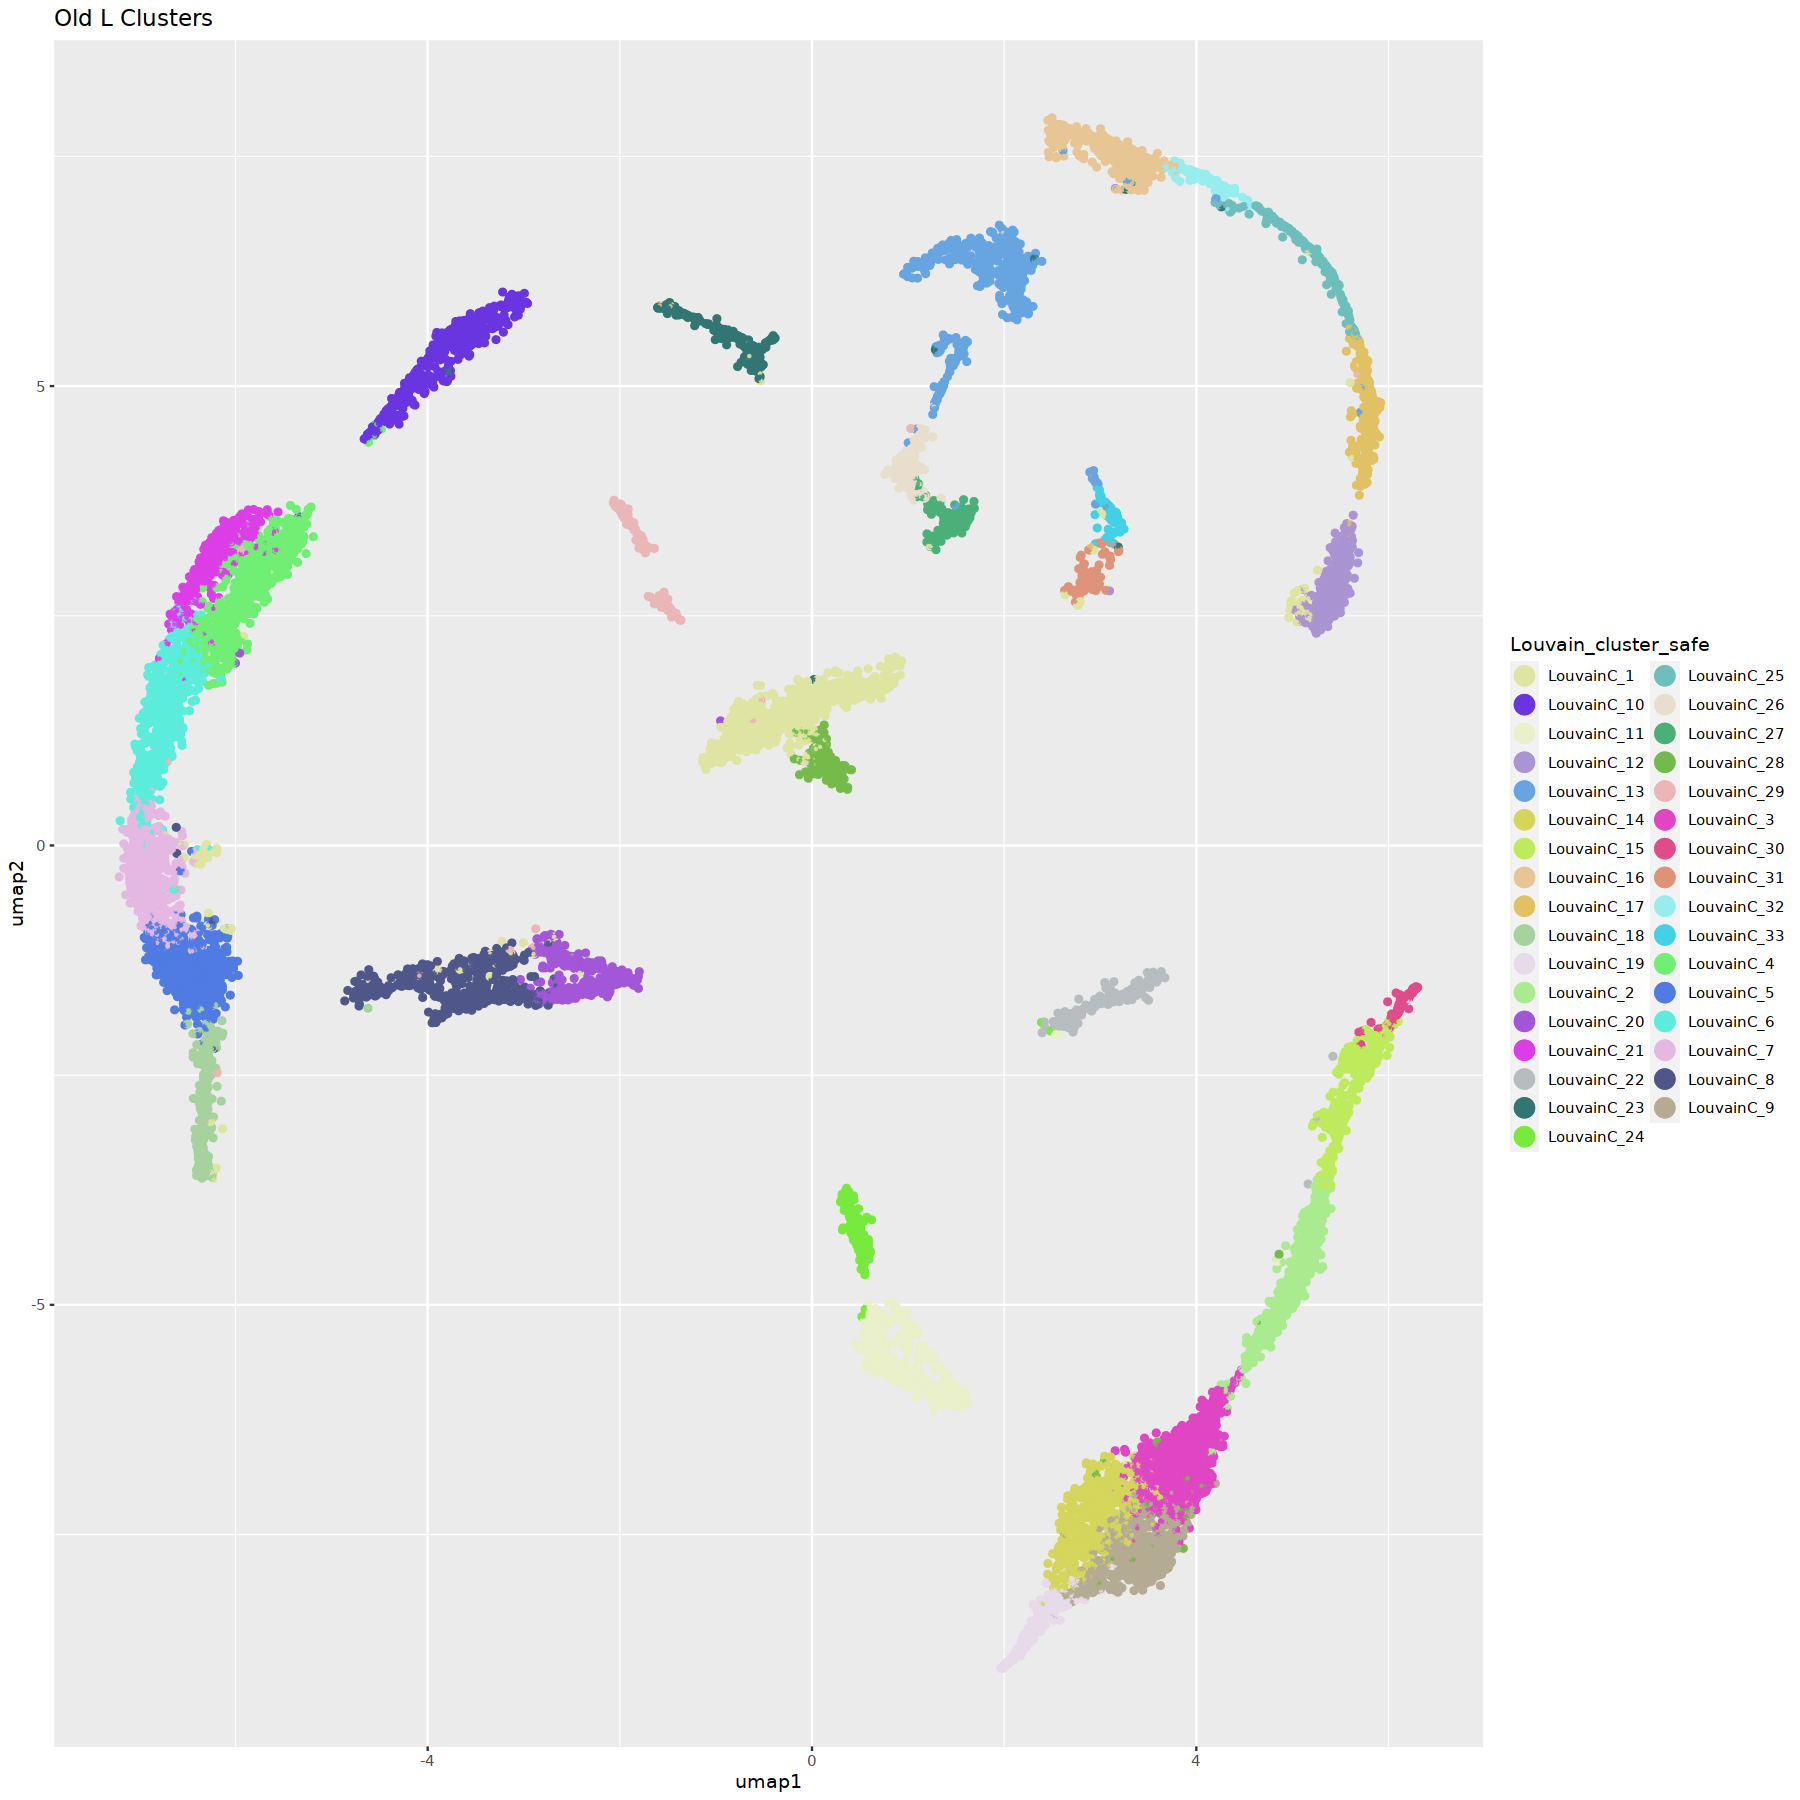

In [7]:
library(cowplot)
library(randomcoloR)
options(repr.plot.width=15, repr.plot.height=15)
other <- randomcoloR::distinctColorPalette(k = 55)
other <- sample(other)


Sb.subcluster.epidermal <- Sb.subcluster


#c("LouvainC_18","LouvainC_5","LouvainC_7","LouvainC_32",
#  "LouvainC_24","LouvainC_21","LouvainC_8","LouvainC_20","LouvainC_23")

sb.loaded_socrates_data.epidermal$Clusters  %>% 
    group_by(Louvain_cluster_safe) %>% 
    ggplot(., aes(umap1, umap2, color = Louvain_cluster_safe)) + geom_point() +
 scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Old L Clusters")

chosen_subcluster <- sb.loaded_socrates_data.epidermal$Clusters

meta_df <- as.data.frame(chosen_subcluster)
rownames(meta_df) <- meta_df$cellID
Sb.subcluster.epidermal$meta <- meta_df
Sb.subcluster.epidermal$meta.v3 <- meta_df

Sb.subcluster.epidermal$acr <- read.table("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/Sb_peak_calls/Sb.peaks/Sb.peaks.500bp_peaks.bed")

In [8]:
Sb.subcluster.epidermal <- generateMatrix(Sb.subcluster.epidermal, 
                                              filtered=FALSE,
                                              peaks = TRUE,
                                              verbose=TRUE)

In [9]:
Sb.subcluster.epidermal <- convertSparseData(Sb.subcluster.epidermal, verbose = TRUE)

 - converting triplet format to sparseMatrix



In [10]:
# clean sparse counts matrix ---------------------------------------------
Sb.subcluster.epidermal.clean <- cleanData(Sb.subcluster.epidermal, 
                     min.t=0.005,  # minimum feature frequency across cells
                     max.t=0.1, # maximum feature frequency across cells
                     verbose=T)


   * Input: cells = 14886 | peaks = 67812

   * Filtered: cells = 14726 | peaks = 50116



In [11]:
Sb.subcluster.epidermal.clean$meta  %>% 
    group_by(Louvain_cluster_safe)  %>% 
    summarise(n())
    

Louvain_cluster_safe,n()
<chr>,<int>
LouvainC_1,840
LouvainC_10,577
LouvainC_11,578
LouvainC_12,587
LouvainC_13,533
LouvainC_14,535
LouvainC_15,483
LouvainC_16,457
LouvainC_17,446


In [12]:
# normalize with TFIDF ---------------------------------------------------
Sb.subcluster.epidermal.tfidf <- tfidf(Sb.subcluster.epidermal.clean)

In [13]:
# project with NMF -------------------------------------------------------
Sb.subcluster.epidermal.tfidf <- reduceDims(Sb.subcluster.epidermal.tfidf,
                      method="SVD", 
                      n.pcs=30, 
                      svd_slotName="SVD")

 - non-linear dimensionality reduction with UMAP ...

09:23:24 UMAP embedding parameters a = 1.896 b = 0.8006

09:23:24 Read 14726 rows and found 30 numeric columns

09:23:24 Using Annoy for neighbor search, n_neighbors = 15

09:23:24 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:23:26 Writing NN index file to temp file /tmp/RtmpcH6Aup/file679b76573631

09:23:26 Searching Annoy index using 16 threads, search_k = 1500

09:23:26 Annoy recall = 100%

09:23:38 Commencing smooth kNN distance calibration using 16 threads
 with target n_neighbors = 15

09:23:44 Initializing from normalized Laplacian + noise (using irlba)

09:23:44 Commencing optimization for 200 epochs, with 376060 positive edges

09:24:06 Optimization finished



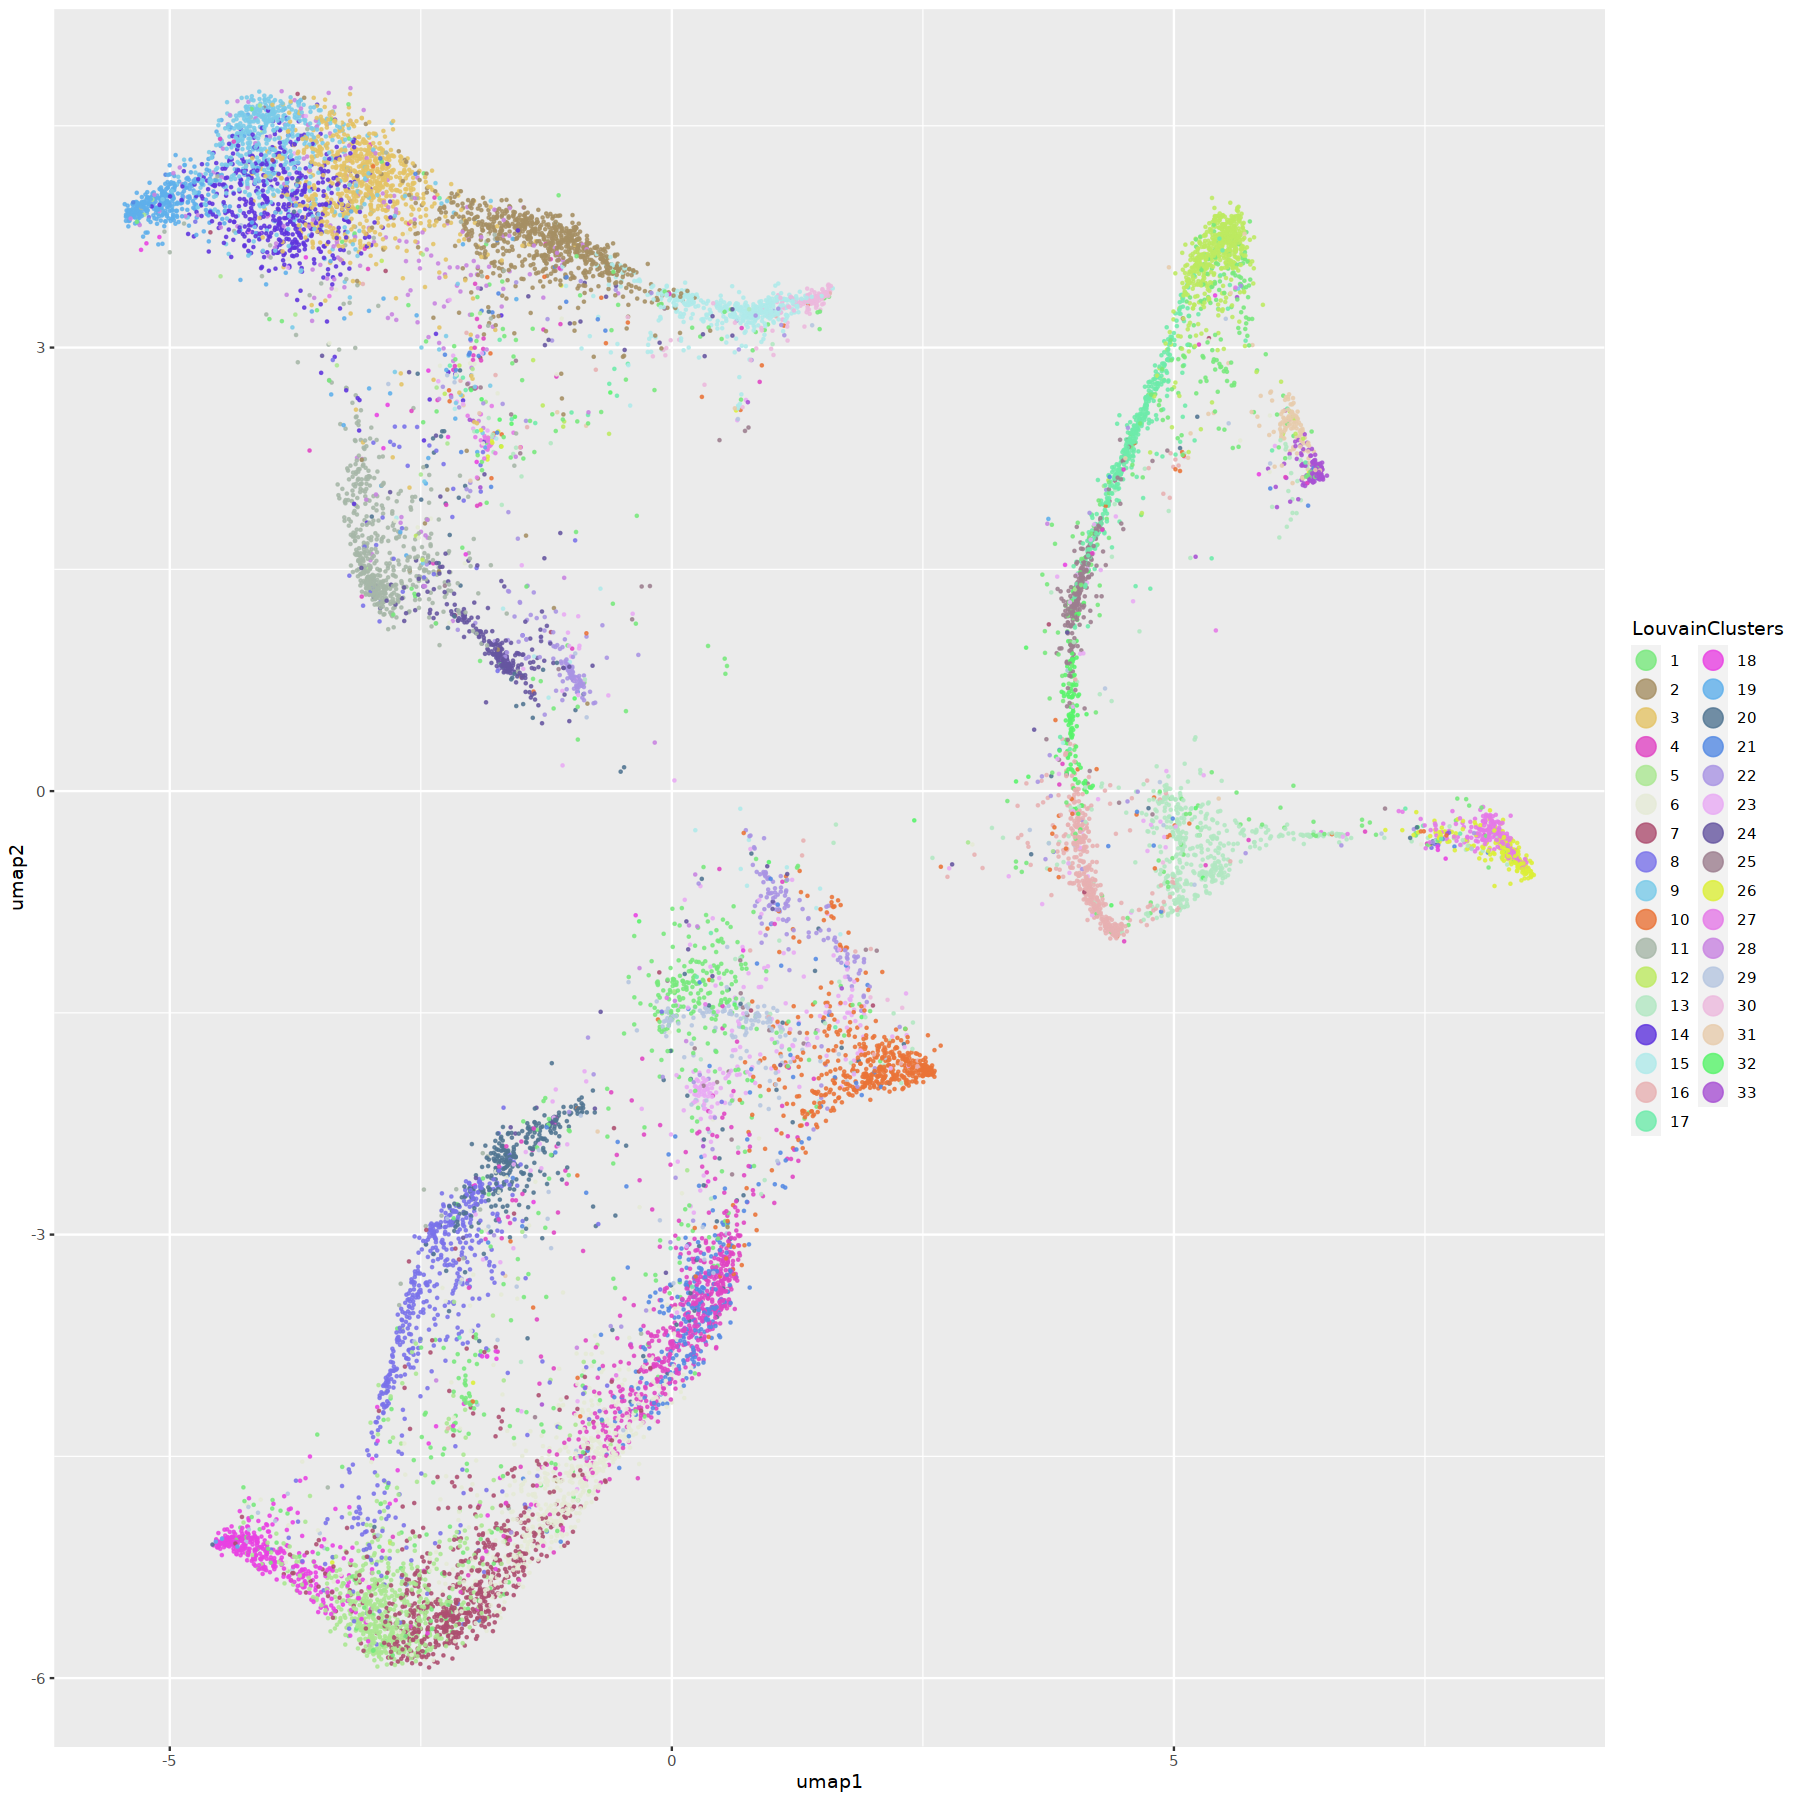

In [14]:
# reduce to 2-dimensions with UMAP ---------------------------------------
Sb.subcluster.epidermal.tfidf <- projectUMAP(Sb.subcluster.epidermal.tfidf, 
                       verbose=T,
                       k.near=15,
                       m.dist=0.01,
                       svd_slotName="SVD")

library(randomcoloR)
other <- randomcoloR::distinctColorPalette(k = 55)
other <- sample(other)

ggplot(Sb.subcluster.epidermal.tfidf$meta, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8)

In [15]:
# identify clusters using neighborhood graph -----------------------------
Sb.subcluster.epidermal.tfidf.clusters <- callClusters(Sb.subcluster.epidermal.tfidf, 
                        res=4,
                        k.near = 10,
                        #min.reads=1000,
                        verbose=T,
                        svd_slotName= "SVD",
                        cluster_slotName="sub_cluster",
                        cleanCluster=FALSE)


 - filtering outliers in UMAP manifold (z-score e.thresh = 3) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14466
Number of edges: 335655

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.7517
Number of communities: 49
Elapsed time: 10 seconds


12 singletons identified. 37 final clusters.

 - finished graph-based clustering ...

 - filtering clusters with low cell/read counts ...



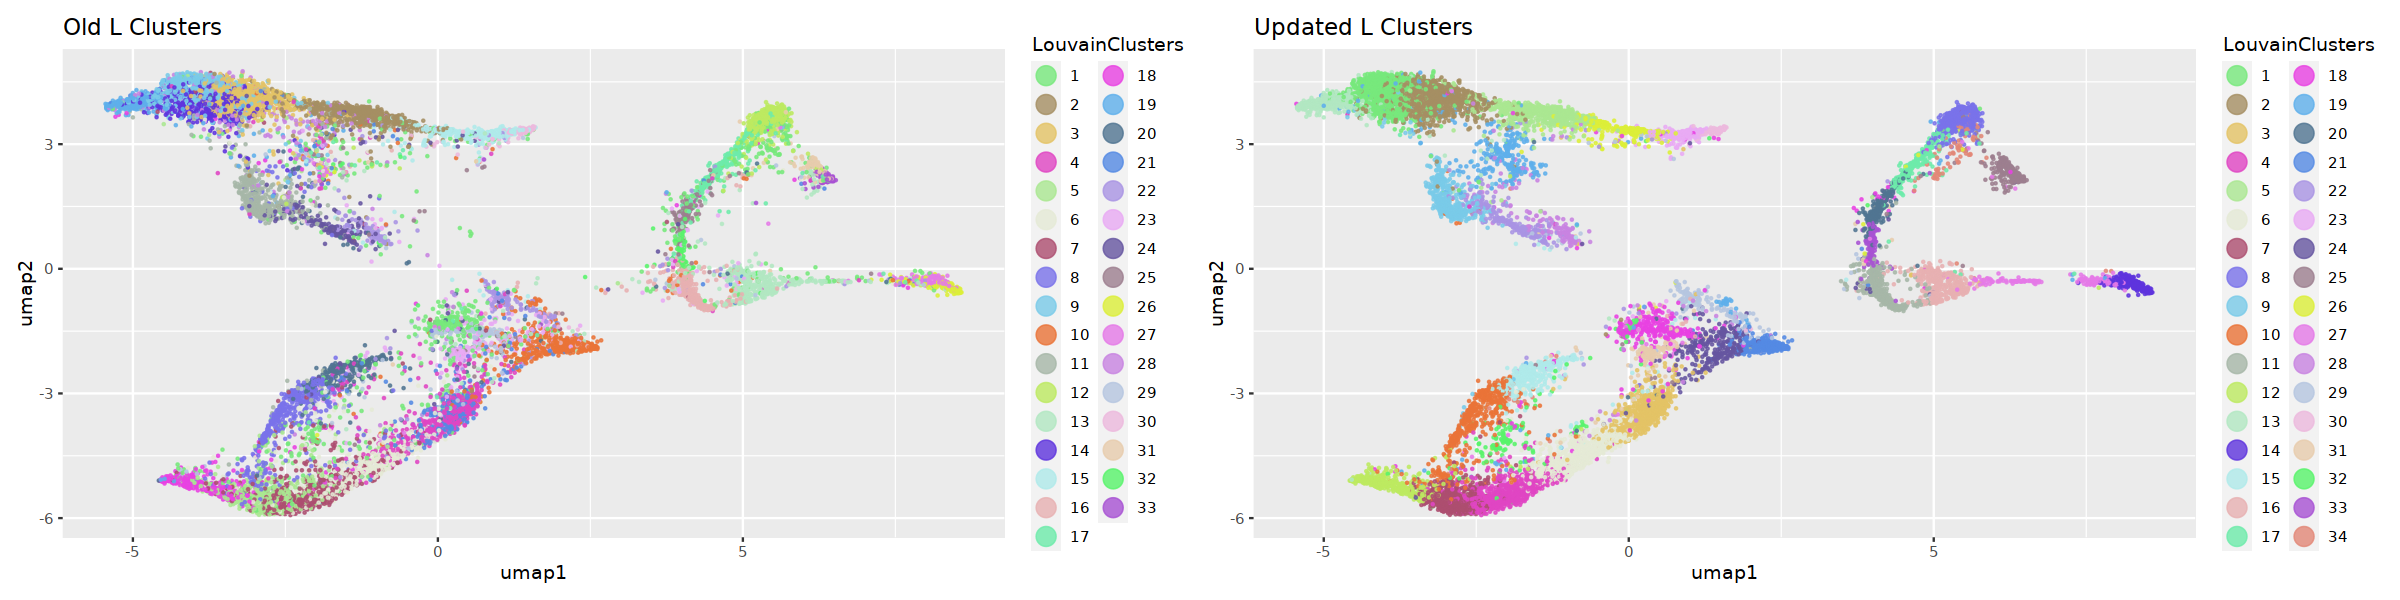

In [16]:
options(repr.plot.width=20, repr.plot.height=5)

old_clusters <- ggplot(Sb.subcluster.epidermal.tfidf.clusters$meta, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8)+ ggtitle("Old L Clusters")

new_clusters <- ggplot(Sb.subcluster.epidermal.tfidf.clusters$sub_cluster, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Updated L Clusters")


old_clusters + new_clusters 

In [17]:
Sb.subcluster.epidermal.tfidf.clusters$sub_cluster  %>% 
    group_by(LouvainClusters)  %>% 
    summarise(n())

LouvainClusters,n()
<fct>,<int>
1,955
2,946
3,729
4,728
5,718
6,708
7,644
8,620
9,514


In [18]:
sb_annotation_v3 <- read_tsv("/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/Sb_leaf.V3_final.txt", 
                                    )
sb_annotation_v3.final <- sb_annotation_v3  %>% 
    dplyr::select(cellID, V3_final_annnotation)

Rows: 14947 Columns: 25
── Column specification ───────────────────────────────────────────────────────────
Delimiter: "\t"
chr (13): cellID, sampleID, d.type, cell_annotation_glmnet, cell_annotation_...
dbl (12): total, tss, acrs, ptmt, nSites, log10nSites, umap1, umap2, doublet...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


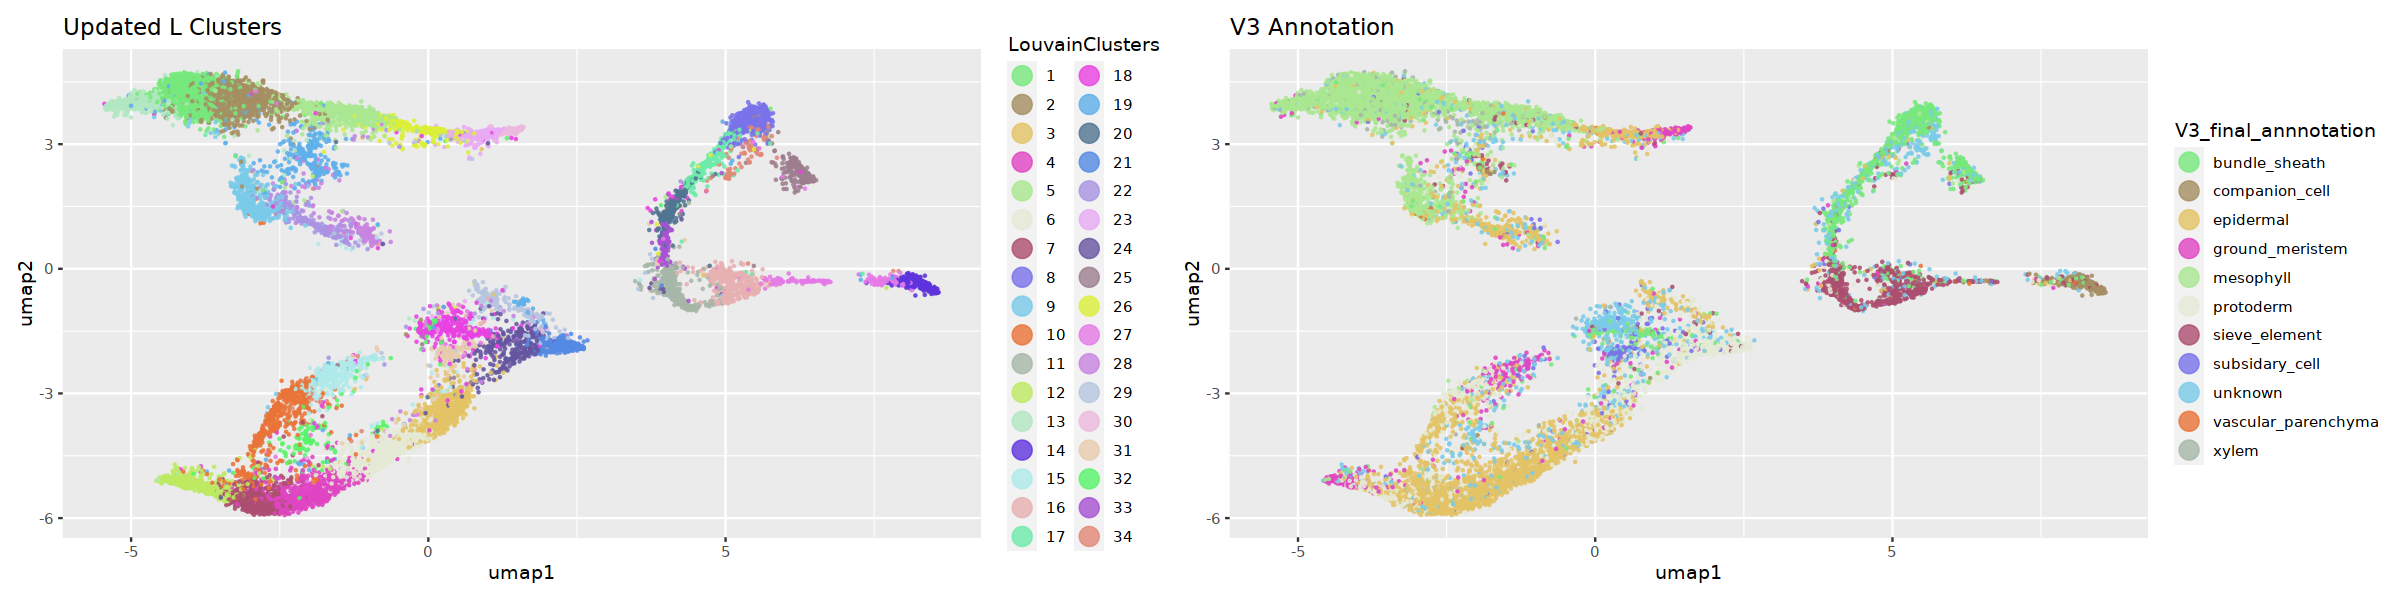

In [19]:


final_joined <- left_join(Sb.subcluster.epidermal.tfidf.clusters$sub_cluster, sb_annotation_v3.final, by = "cellID")


new_clusters <- ggplot(Sb.subcluster.epidermal.tfidf.clusters$sub_cluster, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Updated L Clusters")



old_annot <- ggplot(final_joined, aes(x=umap1, y = umap2, color = V3_final_annnotation)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("V3 Annotation")

new_clusters + old_annot


In [20]:
prefix <- "Sb_leaf.merged_replicates.acr_bins"
output_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering"

nmf.rd <- Sb.subcluster.epidermal.tfidf.clusters$SVD
write.table(nmf.rd, file=paste0(output_location, prefix, ".SVD.full.reduced_dimensions.txt"), quote=F, row.names=T, col.names=T, sep="\t")


In [21]:
head(sb_annotation_v3.final)

cellID,V3_final_annnotation
<chr>,<chr>
BC:Z:ACAGTGAGTCAAAAACAACTGATGGAA-Sorghum_leaf.sciATAC_rep1,protoderm
BC:Z:ACAGTGAGTCAAAAACAATTCCTTCAT-Sorghum_leaf.sciATAC_rep1,epidermal
BC:Z:ACAGTGAGTCAAAAACAGAGTGGCGAG-Sorghum_leaf.sciATAC_rep1,mesophyll
BC:Z:ACAGTGAGTCAAAAACAGGTAGCGATG-Sorghum_leaf.sciATAC_rep1,vascular_parenchyma
BC:Z:ACAGTGAGTCAAAAACAGTCCGCAGCT-Sorghum_leaf.sciATAC_rep1,companion_cell
BC:Z:ACAGTGAGTCAAAAACAGTTTCGTTCC-Sorghum_leaf.sciATAC_rep1,epidermal


In [22]:
sb_annotation_v3.final

cellID,V3_final_annnotation
<chr>,<chr>
BC:Z:ACAGTGAGTCAAAAACAACTGATGGAA-Sorghum_leaf.sciATAC_rep1,protoderm
BC:Z:ACAGTGAGTCAAAAACAATTCCTTCAT-Sorghum_leaf.sciATAC_rep1,epidermal
BC:Z:ACAGTGAGTCAAAAACAGAGTGGCGAG-Sorghum_leaf.sciATAC_rep1,mesophyll
BC:Z:ACAGTGAGTCAAAAACAGGTAGCGATG-Sorghum_leaf.sciATAC_rep1,vascular_parenchyma
BC:Z:ACAGTGAGTCAAAAACAGTCCGCAGCT-Sorghum_leaf.sciATAC_rep1,companion_cell
BC:Z:ACAGTGAGTCAAAAACAGTTTCGTTCC-Sorghum_leaf.sciATAC_rep1,epidermal
BC:Z:ACAGTGAGTCAAACCCCACTGATACCG-Sorghum_leaf.sciATAC_rep1,epidermal
BC:Z:ACAGTGAGTCAAACCCCATGAGCTTCC-Sorghum_leaf.sciATAC_rep1,epidermal
BC:Z:ACAGTGAGTCAAACCCCATTCCTGCTC-Sorghum_leaf.sciATAC_rep1,epidermal


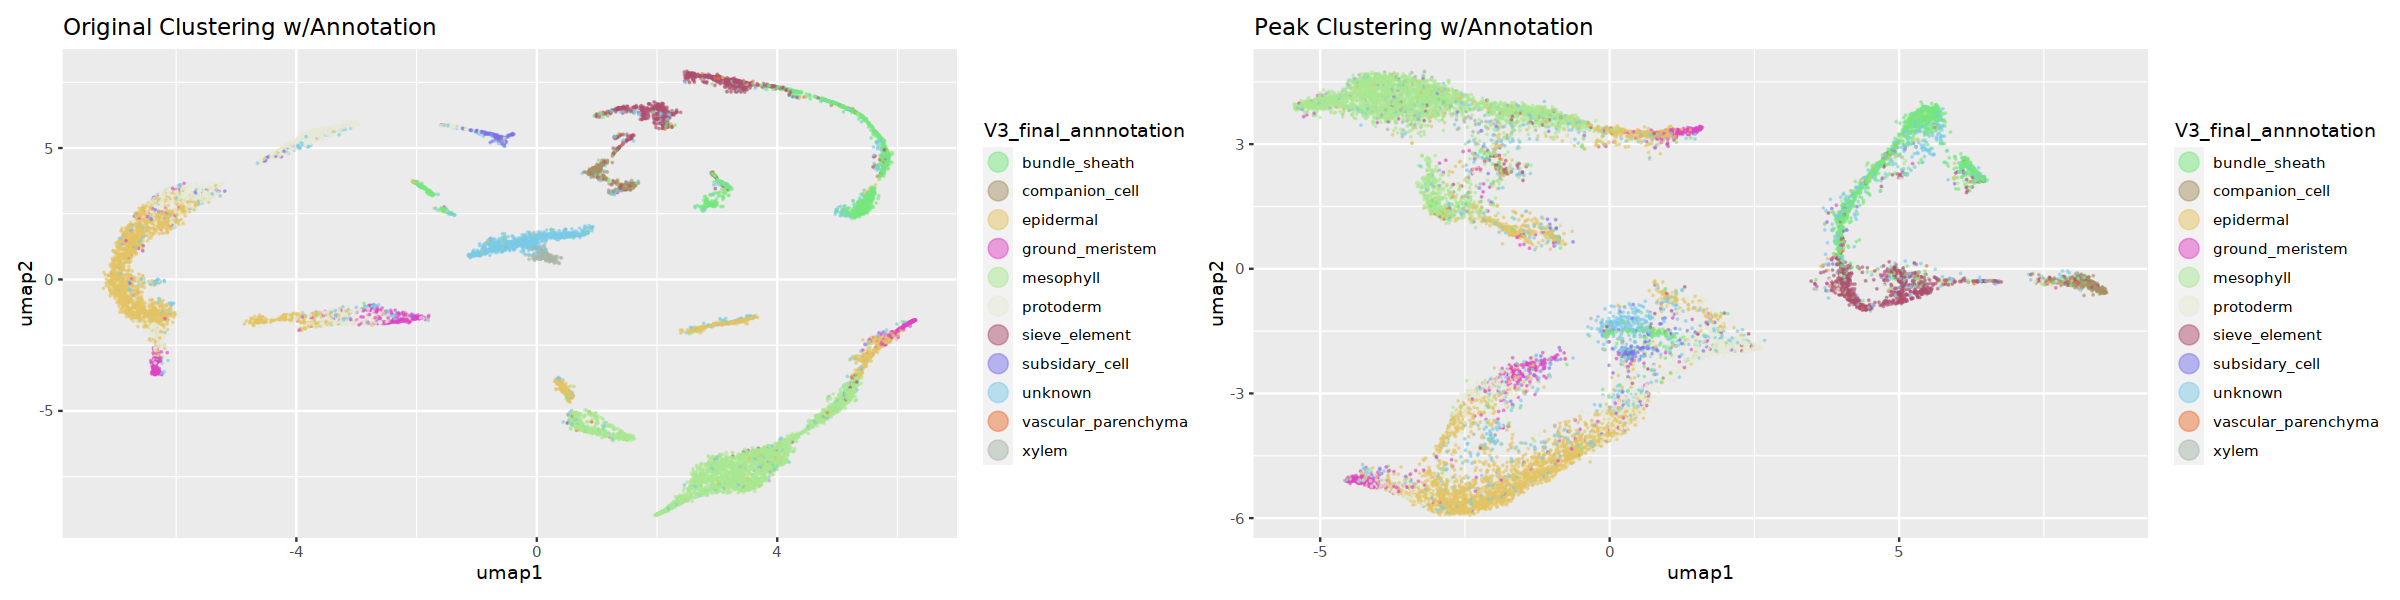

In [23]:


final_joined <- left_join(Sb.subcluster.epidermal.tfidf.clusters$sub_cluster, sb_annotation_v3.final, by = "cellID")


original_clustering <- ggplot(sb_annotation_v3, aes(x=umap1, y = umap2, color = V3_final_annnotation)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .05, alpha = .5) + ggtitle("Original Clustering w/Annotation")



updated_clustering <- ggplot(final_joined, aes(x=umap1, y = umap2, color = V3_final_annnotation)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .05, alpha = .5) + ggtitle("Peak Clustering w/Annotation")

original_clustering + updated_clustering


In [24]:

prefix <- "Sb_leaf.peak_clustering"
output_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/"

# output text files
nmf.meta <- Sb.subcluster.epidermal.tfidf.clusters$sub_cluster
nmf.rd <- Sb.subcluster.epidermal.tfidf.clusters$SVD

write.table(nmf.meta, file=paste0(output_location,prefix, ".SVD.full.metadata.txt"), quote=F, row.names=T, col.names=T, sep="\t")
write.table(nmf.rd, file=paste0(output_location, prefix, ".SVD.full.reduced_dimensions.txt"), quote=F, row.names=T, col.names=T, sep="\t")


#Generate Sparse Matrix-
trip <- as.data.frame(summary(Sb.subcluster.epidermal.tfidf.clusters$counts))
trip$i <- rownames(Sb.subcluster.epidermal.tfidf.clusters$counts)[trip$i]
trip$j <- colnames(Sb.subcluster.epidermal.tfidf.clusters$counts)[trip$j]

write.table(trip, file=paste0(output_location, prefix, ".SVD.sparse"), quote=F, row.names=T, col.names=T, sep="\t")



In [25]:
library("presto")
run_presto <- function(meta_obj, 
                       meta_slot = "Clusters", 
                       cluster_name = "LouvainClusters", 
                       counts_raw="acr_counts_raw"){
    ### Pull the correct meta datafrom the Socrates Object
    sparse_matrix <- meta_obj[[counts_raw]]
    meta_data <- meta_obj[[meta_slot]]
    
    print(head(as_tibble(meta_data)))
        
    ### Read the Giant Sparse Matrix
    loaded_sparse_matric <- read_delim(sparse_matrix, delim='\t', 
                                       col_names = c("gene_name", "barcode", "accessability"), 
                                       col_types = "ccn")
    
    print(head(loaded_sparse_matric))
    combined_large_w_sparse <- loaded_sparse_matric  %>% 
        filter(gene_name != "Annotation")  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        left_join(., meta_data, by = c("barcode" = "cellID"))  %>% 
        filter(is.na(!!sym(cluster_name)) != TRUE)  %>% 
        arrange(!!sym(cluster_name))
    
    #order <- combined_large_w_sparse[!!sym(cluster_name)]

    combined_large_w_sparse <- combined_large_w_sparse  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        mutate(across(accessability, as.numeric))
    
    
    gene_names <- unique(combined_large_w_sparse$gene_name)
    barcodes <- unique(combined_large_w_sparse$barcode)

    combined_large_w_sparse$row <- match(combined_large_w_sparse$gene_name, gene_names)
    combined_large_w_sparse$col <- match(combined_large_w_sparse$barcode, barcodes)


    UIMatrix <- sparseMatrix(i = combined_large_w_sparse$row,
                         j = combined_large_w_sparse$col,
                         x = combined_large_w_sparse$accessability,
                         dimnames=list(gene_names, barcodes))

    print(head(tibble(barcode = unlist(UIMatrix@Dimnames[2]))))
    barcode_tibble <- tibble(barcode = unlist(UIMatrix@Dimnames[2])) %>% 
        left_join(., as_tibble(meta_data), by = c("barcode" = "cellID"))  %>% 
        filter(is.na(total) != TRUE)
    
    print(dim(barcode_tibble))
    print(dim(UIMatrix))
    
    clust_name <- c(cluster_name)
    garbbed_louv_order <- pull(barcode_tibble,!!sym(clust_name))

    sparse_matrix_test <- wilcoxauc(UIMatrix, garbbed_louv_order)
    
    meta_obj[["presto_marker"]] <- sparse_matrix_test
    
    return(meta_obj)
}


Loading required package: data.table


Attaching package: 'data.table'


The following object is masked from 'package:slam':

    rollup


The following object is masked from 'package:GenomicRanges':

    shift


The following object is masked from 'package:IRanges':

    shift


The following objects are masked from 'package:S4Vectors':

    first, second


The following objects are masked from 'package:dplyr':

    between, first, last


The following object is masked from 'package:purrr':

    transpose


The following objects are masked from 'package:reshape2':

    dcast, melt




In [26]:
setwd("/scratch/jpm73279/comparative_single_cell/dev_location")
Sb.subcluster.epidermal.tfidf.clusters$all_genes <- "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sbicolorv5.1.gene.bed"
#bed_intersections <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/zea_mays/Zm.all_mergeed_repds.unique.mpq10.tn5.sorted.bed"
genome_file <- "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sorghum_bicolor_var_BTx623.mainGenome.MtPt.fasta.fai"

### Kernal Corrupted to just linked to the previosly run gene body accessability calculations
tfidf.obj.dob.filt.clusters.counts <- Sb.subcluster.epidermal.tfidf.clusters
tfidf.obj.dob.filt.clusters.counts$acr_counts_raw <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/Sb.gene_counts.output"

## Execute Annotation Attempt #1

library(presto)
Sb.subcluster.tfidf.clusters.final <- run_presto(tfidf.obj.dob.filt.clusters.counts,
           meta_slot = "sub_cluster",
           counts_raw = "acr_counts_raw",
           cluster_name = "LouvainClusters")

# A tibble: 6 × 14
  cellID    total   tss  acrs  ptmt nSites log10…¹ sampl…²  umap1  umap2 doubl…³
  <chr>     <dbl> <dbl> <dbl> <dbl>  <dbl>   <dbl> <chr>    <dbl>  <dbl>   <dbl>
1 BC:Z:CG… 159908 50092 29336     0  13716    4.14 rep1     0.552 -0.894   0.612
2 BC:Z:TT… 137820 80881 99700     0  25193    4.40 rep1     0.407 -0.860   0.576
3 BC:Z:AC… 116704 44610 44540     0  15274    4.18 rep1    -2.41   2.34    0.635
4 BC:Z:TG… 115159 66137 88585     0  22826    4.36 rep1    -1.44   1.39    0.788
5 BC:Z:AC…  99224 62412 83029     0  20830    4.32 rep1     7.49  -0.272   0.659
6 BC:Z:AC…  98568 56617 71027     0  20475    4.31 rep1     0.230 -2.00    0.482
# … with 3 more variables: d.type <chr>, LouvainClusters <fct>,
#   Louvain_cluster_safe <chr>, and abbreviated variable names ¹​log10nSites,
#   ²​sampleID, ³​doubletscore
# A tibble: 6 × 3
  gene_name        barcode                                               acces…¹
  <chr>            <chr>                                     

In [30]:
grabbed_top_marker_per_cluster <- top_markers(Sb.subcluster.tfidf.clusters.final$presto_marker, 200)


represented_marker_lst <- list()
for (i in unique(Sb.subcluster.tfidf.clusters.final$sub_cluster$LouvainClusters)) {
    
    make_set <- setNames("geneID",i) 
    markers_present_in_presto <- left_join(grabbed_top_marker_per_cluster, 
                                           marker_list_sb, by = make_set)  %>% 
    dplyr::filter(is.na(chr) != TRUE)  %>% 
    dplyr::select(rank, i, chr:tissue) %>% 
    dplyr::rename("geneID" = i)
    
    represented_marker_lst[[i]] <- markers_present_in_presto
}
                 
represented_marker_lst

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(i)` instead of `i` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


rank,geneID,chr,start,end,name,type,tissue
<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
31,Sobic.002G032500,Chr02,3002965,3011531,pan2,"subsidiary_mother_cell,developing_pavement_cell,cortex",axillaryBud;leaf;crownRoot;root
126,Sobic.007G211200,Chr07,67406141,67408727,pan1,subsidary_mother_cell,axillaryBud;leaf
134,Sobic.001G145200,Chr01,11750927,11755977,cvp2,"phloem_sieve_element_precursors,protophloem_sieve_element",axillaryBud;leaf;crownRoot;root;tassel;ear
182,Sorbiv5.1_pg7389.valid.m23.g,Chr06,60678690,60686342,ZmMP_1__ZmMP_2,procambial_meristem,axillaryBud;leaf;crownRoot;root;tassel;ear
rank,geneID,chr,start,end,name,type,tissue
<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
3,Sorbiv5.1_pg5044.valid.m7.g,Chr01,66616555,66619678,bk1,vascular_sclerenchyma,axillaryBud;leaf;crownRoot;root;tassel;ear
8,Sorbiv5.1_pg9159.m1.g,Chr06,41574374,41588764,ba2,"axillary_meristem,branch_meristem,peripheral_zone_inflorescence_meristem,spikelet_pair_meristem,spikelet_meristem,upper_floral_meristem,lower_floral_meristem,pistil_primordia,stamen_primordia,provascular_strands,glume_primordia,lemma_primordia,palea_primordia",axillaryBud;leaf;tassel;ear
107,Sobic.002G343500,Chr02,72301461,72308725,ZmCPK37__ZmCPK35,guard_cell,axillaryBud;leaf


In [31]:
gathered_markers <- bind_rows(represented_marker_lst, .id = "LouvainCluster")  %>% 
    arrange(LouvainCluster, rank)

gathered_markers

LouvainCluster,rank,geneID,chr,start,end,name,type,tissue
<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,1,Sobic.010G160700,Chr10,48834723,48842334,pepc1,mesophyll,axillaryBud;leaf
1,11,Sorbiv5.1_pg15362.valid.m24.g,Chr03,63610236,63623676,cah1,mesophyll,axillaryBud;leaf
1,111,Sobic.005G042000,Chr05,3935393,3936843,ssu2__ssu1,bundle_sheath,axillaryBud;leaf
10,2,Sobic.002G207900,Chr02,61233338,61239219,gl1,epidermis,axillaryBud;leaf;crownRoot;root
10,106,Sobic.001G537300,Chr01,84195608,84203525,rld1,"SAM,leaf_primordia,provascular_strands,protoxylem",axillaryBud;leaf
10,114,Sorbiv5.1_pg15531.m1.g,Chr03,3341071,3347117,me3_ortho_count_1,bundle_sheath,axillaryBud;leaf
11,144,Sobic.007G211200,Chr07,67406141,67408727,pan1,subsidary_mother_cell,axillaryBud;leaf
12,8,Sobic.002G207900,Chr02,61233338,61239219,gl1,epidermis,axillaryBud;leaf;crownRoot;root
12,17,Sorbiv5.1_pg15531.m1.g,Chr03,3341071,3347117,me3_ortho_count_1,bundle_sheath,axillaryBud;leaf


In [32]:

write_delim(gathered_markers, 
            "/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/V3_annotations/Sb_leaf.merged_replicates.peak_clustering.txt", 
            col_names = TRUE, quote = "none", delim = "\t")

gathered_markers

LouvainCluster,rank,geneID,chr,start,end,name,type,tissue
<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,1,Sobic.010G160700,Chr10,48834723,48842334,pepc1,mesophyll,axillaryBud;leaf
1,11,Sorbiv5.1_pg15362.valid.m24.g,Chr03,63610236,63623676,cah1,mesophyll,axillaryBud;leaf
1,111,Sobic.005G042000,Chr05,3935393,3936843,ssu2__ssu1,bundle_sheath,axillaryBud;leaf
10,2,Sobic.002G207900,Chr02,61233338,61239219,gl1,epidermis,axillaryBud;leaf;crownRoot;root
10,106,Sobic.001G537300,Chr01,84195608,84203525,rld1,"SAM,leaf_primordia,provascular_strands,protoxylem",axillaryBud;leaf
10,114,Sorbiv5.1_pg15531.m1.g,Chr03,3341071,3347117,me3_ortho_count_1,bundle_sheath,axillaryBud;leaf
11,144,Sobic.007G211200,Chr07,67406141,67408727,pan1,subsidary_mother_cell,axillaryBud;leaf
12,8,Sobic.002G207900,Chr02,61233338,61239219,gl1,epidermis,axillaryBud;leaf;crownRoot;root
12,17,Sorbiv5.1_pg15531.m1.g,Chr03,3341071,3347117,me3_ortho_count_1,bundle_sheath,axillaryBud;leaf


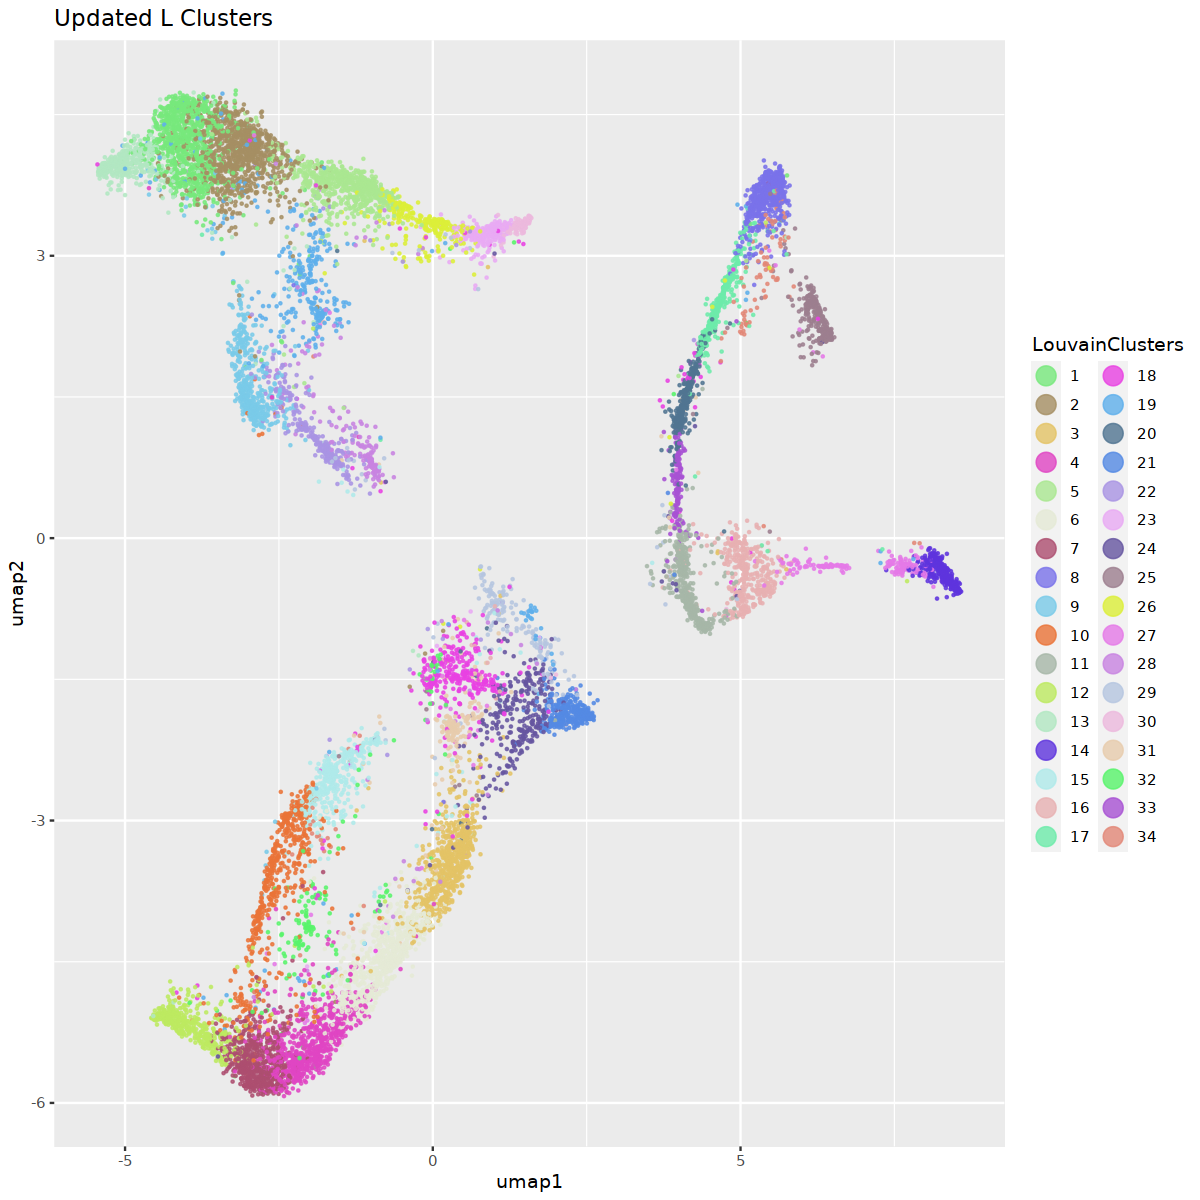

In [33]:
options(repr.plot.width=10, repr.plot.height=10)
new_clusters

In [34]:
prefix

[1] "Sb_leaf.peak_clustering"

In [35]:
saveRDS(Sb.subcluster.epidermal.tfidf.clusters, file = paste0(output_location,prefix, ".SVD.full.rds"))